<a href="https://colab.research.google.com/github/pabloinsente/CovNet_Human_Drawings/blob/master/code/model_training_hyperparameter_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model training and hyperparameter optimization for Age-prediction
Here we use Keras and the Talos library to set up the hyperparameter optimization. 

***Warning***: since we are using colab, we need to (1) install talos (2) re-start the running environment AFTER installing Talos (to update some packages that Talos needs to un) before running the optimization.  

In [0]:
!pip install talos
!pip install rarfile

In [1]:
# Let's import Talos, Keras, and dependencies

import talos as ta
from talos.metrics.keras_metrics import precision_acc, recall_acc, matthews_correlation_acc, fmeasure_acc
from talos.model.normalizers import lr_normalizer
from talos.utils.best_model import best_model, activate_model
from talos import Predict

from keras.activations import relu, elu, sigmoid
from keras.optimizers import Adam, Nadam, RMSprop
from keras.losses import binary_crossentropy, logcosh
from keras.models import Sequential
from keras.layers import Dense, Dropout

from sklearn.model_selection import train_test_split

from imblearn.over_sampling import RandomOverSampler 

import pandas as pd
from numpy import genfromtxt
from collections import Counter
import rarfile, csv

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


## Data preparation
First, we need to split the data into training and testing as usual. The training dataset will be feed into the model training and optimization process The testing data will be used to evalute the model. 

In [0]:
# Clone the data into Colab
! git clone https://github.com/pabloinsente/CovNet_Human_Drawings

In [3]:
# Read csv files from compressed rar file and convert into a dataframe
rar_path = rarfile.RarFile("CovNet_Human_Drawings/data/merged_dataframes_prediction/x_drawings_features_max_pool_5.rar")
csv_file_name = "x_drawings_features_max_pool_5.csv"
rar_file = rarfile.RarFile.open(rar_path, csv_file_name)
x = pd.read_csv(rar_file, sep=",", header=None)
print(x.shape)
print(x.iloc[0:5,0:5])

(258, 25088)
          0    1    2         3         4
0 -0.001317  0.0  0.0 -0.001322 -0.003181
1 -0.001052  0.0  0.0 -0.001056 -0.002540
2 -0.001176  0.0  0.0 -0.001181 -0.002840
3 -0.000836  0.0  0.0 -0.000839 -0.000957
4 -0.001163  0.0  0.0 -0.001168  0.011156


In [4]:
x = x.values # as numpy array
print(type(x))
print(x.shape)

<class 'numpy.ndarray'>
(258, 25088)


In [5]:
# Read labels vector
y_path = 'CovNet_Human_Drawings/data/merged_dataframes_prediction/y_age_adult_labels.csv'
y = genfromtxt(y_path, delimiter=',')

#x = x.drop([0]) # drop headers
print(y.shape)
print(y[0:5])

(258,)
[0. 0. 0. 0. 0.]


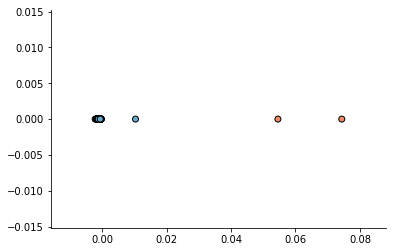

In [6]:
# Let's look at the distribution of 0s and 1s

colors = ['#ef8a62' if v == 0 else '#67a9cf' for v in y]
kwarg_params = {'linewidth': 1, 'edgecolor': 'black'}
fig = plt.Figure(figsize=(12,6))
plt.scatter(x[:, 0], x[:, 1], c=colors, **kwarg_params)
sns.despine()

In [7]:
# Split data into train and test sets
# Since we have an small sample, we will do a 70/30 split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state=44)
print(x_train.shape) 
print(y_train.shape) 
print(x_test.shape) 
print(y_test.shape)

(180, 25088)
(180,)
(78, 25088)
(78,)


###Resampling imbalanced data
Since our classes are imbalanced, we will use oversampling of the "adult" class **on the training set**  to help training on that class. *imblearn* implement oversampling for us

**See documentantion at** https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.RandomOverSampler.html

In [0]:
ros = RandomOverSampler(random_state=42)
x_train_res, y_train_res = ros.fit_resample(x_train, y_train)

In [9]:
print(x_train_res.shape) # (258, 200)
print(y_train_res.shape) # (258,)
print('Resampled dataset shape %s' % Counter(y_train_res))

# Now we have 50/50 balanced classes

(286, 25088)
(286,)
Resampled dataset shape Counter({1.0: 143, 0.0: 143})


## Model Definition
Here we define the model using Keras. The main point is to pass all the arguments as keys of a Python dictionary instead of variables

In [0]:
# define model
def input_model(x_train, y_train, x_val, y_val, params):
  model = Sequential()
  # add hidden layer
  model.add(Dense(params['first_neuron'], 
                  input_dim=x_train.shape[1], 
                  activation=params['activation'],
                  kernel_initializer = params['kernel_initializer']))
  # add dropout layer
  model.add(Dropout(params['dropout']))
  # add output layer
  model.add(Dense(1,activation=params['last_activation'],
                  kernel_initializer = params['kernel_initializer']))
  # compile model
  model.compile(loss=params['losses'],
                optimizer=params['optimizer'](lr=lr_normalizer(params['lr'], params['optimizer'])),
                metrics=['acc', fmeasure_acc, recall_acc, precision_acc, matthews_correlation_acc])
  # train model
  out = model.fit(x_train, y_train,
                  validation_data=[x_val, y_val],
                  batch_size=params['batch_size'],
                  epochs=params['epochs'],
                  verbose = 0)
  return out, model

## Setting the Parameter Space Boundaries 
here we create a dictionary, which will then be passed on to Talos together with the model above. Here we have three different ways to input values:

- as stepped ranges (min, max, steps)
- as multiple values [in a list]
- as a single value [in a list]

In [0]:
# set hyperparameters to optimize
p = {'first_neuron': [16, 32, 64],
     'activation': [relu, sigmoid],
     'optimizer': [Nadam, Adam],
     'losses':[binary_crossentropy],
     'hidden_layers':[0, 1, 2],
     'batch_size': [10, 20, 40],
     'epochs':[150, 300],
     'dropout': [0, 0.1, 0.2],
     'kernel_initializer': ['uniform','normal'],
     'lr':[0.01, 0.1, 0.2],
     'last_activation': ['sigmoid']} 

## Running the hyperparameter optimization with Scan() 
Now we are ready to run the model based on the parameters and the layer configuration above. The exact same process would apply with any other model, just make sure to pass the model function name in the Scan() command as in the below example.



In [12]:
# starting optimization
h = ta.Scan(x= x_train_res, y=y_train_res,
            params=p,
            model=input_model,
            # I use .29 split because that is ~20% of all data
            val_split = 0.29,
            dataset_name='Draw_a_person',
            experiment_no='experiment_1',
            grid_downsample=.15)

  0%|          | 0/583 [00:00<?, ?it/s]

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


  0%|          | 1/583 [00:20<3:21:43, 20.80s/it]

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


100%|██████████| 583/583 [3:03:24<00:00, 18.93s/it]


## Accessing the results through the Scan object
The scan object saves all the necessary information for analysis and deployment
**See source code at** https://github.com/autonomio/talos/blob/daily-dev/talos/scan/Scan.py

In [13]:
# accessing the results data frame
h.data[0:3]

,round_epochs,val_loss,val_acc,val_fmeasure_acc,val_recall_acc,val_precision_acc,val_matthews_correlation_acc,loss,acc,fmeasure_acc,...,activation,optimizer,losses,hidden_layers,batch_size,epochs,dropout,kernel_initializer,lr,last_activation
0,150,0.285508,0.975904,0.939516,0.919679,0.963855,0.919638,0.048464,1.000000,1.000000,...,<function sigmoid at 0x7f4e893f9268>,<class 'keras.optimizers.Nadam'>,<function binary_crossentropy at 0x7f4e89446268>,1,10,150,0.0,uniform,0.10,sigmoid
1,150,0.350499,0.843373,0.821711,0.919679,0.819277,0.676645,0.024034,1.000000,1.000000,...,<function relu at 0x7f4e893f9158>,<class 'keras.optimizers.Nadam'>,<function binary_crossentropy at 0x7f4e89446268>,2,10,150,0.1,normal,0.10,sigmoid
2,300,0.681707,0.506024,0.660699,0.963855,0.506024,0.000000,0.674349,0.596059,0.705888,...,<function sigmoid at 0x7f4e893f9268>,<class 'keras.optimizers.Adam'>,<function binary_crossentropy at 0x7f4e89446268>,2,20,300,0.0,normal,0.01,sigmoid


In [0]:
# sort by criteria
# h.data.sort_values('val_acc')

In [14]:
# Best model based on training criteria "val_acc"
# see source code to use https://github.com/autonomio/talos/blob/master/talos/utils/best_model.py

criteria = 'acc'

# get best model id from the scan object based on some acc measure
model_id = best_model(h, criteria, False)
# activate best model based on model id
model = activate_model(h, model_id)
# makes probability predictions based on weights from best model
print(model.predict(x_test)[0:1,]) # print first value
# makes class predictions based on weights from best model
print(model.predict_classes(x_test)[0:9,]) # print first 10

# All in one line
# activate_model(scan_object, best_model(scan_object, 'val_acc', False)).predict(X)

[[0.61290383]]
[[1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]]


In [15]:
# accessing epoch entropy values for each round
h.peak_epochs_df[0:5] # print first 5 rows

,val_loss,val_acc,val_fmeasure_acc,val_recall_acc,val_precision_acc,val_matthews_correlation_acc,loss,acc,fmeasure_acc,recall_acc,precision_acc,matthews_correlation_acc,acc_epoch,loss_epoch
1,149,73,73,149,73,73,149,149,148,148,148,149,0.000531,0.115908
2,149,31,31,149,31,18,148,149,148,148,148,149,0.000762,0.356964
3,299,299,299,299,299,299,299,299,299,299,294,299,0.001131,0.000006
4,149,149,149,3,149,149,148,149,149,149,149,149,0.000921,1.179099
5,249,282,282,4,282,282,257,299,299,299,299,297,0.000594,1.246642


In [16]:
# access the summary details
h.details

random_method                    uniform_mersenne
reduction_method                             None
reduction_interval                             50
reduction_window                               20
grid_downsample                              0.15
reduction_threshold                           0.2
reduction_metric                          val_acc
reduce_loss                                 False
experiment_name        Draw_a_person_experiment_1
complete_time                      05/09/19/15:53
x_shape                              (286, 25088)
y_shape                                    (286,)
dtype: object

In [17]:
# accessing the saved models
h.saved_models[0] # print first model

'{"class_name": "Sequential", "config": {"name": "sequential_1", "layers": [{"class_name": "Dense", "config": {"name": "dense_1", "trainable": true, "batch_input_shape": [null, 25088], "dtype": "float32", "units": 32, "activation": "sigmoid", "use_bias": true, "kernel_initializer": {"class_name": "RandomUniform", "config": {"minval": -0.05, "maxval": 0.05, "seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}, {"class_name": "Dropout", "config": {"name": "dropout_1", "trainable": true, "rate": 0.0, "noise_shape": null, "seed": null}}, {"class_name": "Dense", "config": {"name": "dense_2", "trainable": true, "units": 1, "activation": "sigmoid", "use_bias": true, "kernel_initializer": {"class_name": "RandomUniform", "config": {"minval": -0.05, "maxval": 0.05, "seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, 

In [0]:
# accessing the saved weights for models
# h.saved_weights[0] # print weights first model

## Reporting optimization
In the Scan process, the results are stored round-by-round in the corresponding experiment log which is a .csv file stored in the present working directory. The Reporting() accepts as its source either a file name, or the Scan object.

**See source code to dcide how to use this command** 
https://github.com/autonomio/talos/blob/daily-dev/talos/commands/reporting.py 

In [0]:
# use Scan object as input
r = ta.Reporting(h) # creates report object from scan object
#r = ta.Reporting('Draw_a_person_experiment_3.csv')

In [20]:
# access the dataframe with the results
r.data[0:3]

,round_epochs,val_loss,val_acc,val_fmeasure_acc,val_recall_acc,val_precision_acc,val_matthews_correlation_acc,loss,acc,fmeasure_acc,...,activation,optimizer,losses,hidden_layers,batch_size,epochs,dropout,kernel_initializer,lr,last_activation
0,150,0.285508,0.975904,0.939516,0.919679,0.963855,0.919638,0.048464,1.000000,1.000000,...,<function sigmoid at 0x7f4e893f9268>,<class 'keras.optimizers.Nadam'>,<function binary_crossentropy at 0x7f4e89446268>,1,10,150,0.0,uniform,0.10,sigmoid
1,150,0.350499,0.843373,0.821711,0.919679,0.819277,0.676645,0.024034,1.000000,1.000000,...,<function relu at 0x7f4e893f9158>,<class 'keras.optimizers.Nadam'>,<function binary_crossentropy at 0x7f4e89446268>,2,10,150,0.1,normal,0.10,sigmoid
2,300,0.681707,0.506024,0.660699,0.963855,0.506024,0.000000,0.674349,0.596059,0.705888,...,<function sigmoid at 0x7f4e893f9268>,<class 'keras.optimizers.Adam'>,<function binary_crossentropy at 0x7f4e89446268>,2,20,300,0.0,normal,0.01,sigmoid


In [21]:
# get the number of rounds in the Scan
r.rounds()

583

In [22]:
# get the highest result ('val_acc' by default)
r.high()

0.9759036374379353

In [23]:
# get the highest result for any metric
print("F-measure accuracy:", r.high('val_fmeasure_acc'))
print("Training accuracy:", r.high('acc'))
print("Validation accuracy:", r.high('val_acc'))
print("Validation recall accuracy:", r.high('val_recall_acc'))
print("Validation precision accuracy:", r.high('val_precision_acc'))
print("Validation matthews correlation accuracy:", r.high('val_matthews_correlation_acc'))

F-measure accuracy: 0.9401207659617964
Training accuracy: 1.0
Validation accuracy: 0.9759036374379353
Validation recall accuracy: 0.963855421686747
Validation precision accuracy: 0.963855421686747
Validation matthews correlation accuracy: 0.9196377231414059


In [60]:
# get the round with the best result for each of these criteria
# here we say "grab the model/net with the highest score on X criteria and return id/round"
criteria_list= ['acc', 'fmeasure_acc', 'recall_acc', 'precision_acc', 'matthews_correlation_acc',
               'val_acc', 'val_fmeasure_acc', 'val_recall_acc', 'val_precision_acc', 'val_matthews_correlation_acc']

for i in criteria_list:
  print(i, r.rounds2high(i))

acc 0
fmeasure_acc 0
recall_acc 0
precision_acc 0
matthews_correlation_acc 0
val_acc 63
val_fmeasure_acc 63
val_recall_acc 2
val_precision_acc 0
val_matthews_correlation_acc 0


In [25]:
# get correlation for hyperparameters against a metric
print("Hyperparameters and f-measure accuracy")
print(r.correlate('val_fmeasure_acc'),"\n")
print("Hyperparameters and validation loss")
print(r.correlate('val_loss'),"\n")
print("Hyperparameters and validation accuracy")
print(r.correlate('val_acc'),"\n")
print("Hyperparameters and recall accuracy")
print(r.correlate('val_recall_acc'),"\n")
print("Hyperparameters and precision accuracy")
print(r.correlate('val_precision_acc'))

Hyperparameters and f-measure accuracy
first_neuron     0.150339
hidden_layers    0.050790
batch_size      -0.105363
epochs           0.056669
dropout         -0.040679
lr               0.420795
Name: val_fmeasure_acc, dtype: float64 

Hyperparameters and validation loss
first_neuron    -0.192355
hidden_layers   -0.025059
batch_size       0.226713
epochs          -0.151943
dropout          0.030181
lr              -0.760627
Name: val_loss, dtype: float64 

Hyperparameters and validation accuracy
first_neuron     0.143562
hidden_layers   -0.012443
batch_size      -0.148594
epochs           0.059557
dropout         -0.004099
lr               0.512650
Name: val_acc, dtype: float64 

Hyperparameters and recall accuracy
first_neuron     0.101098
hidden_layers    0.090827
batch_size      -0.035485
epochs           0.050256
dropout         -0.069437
lr               0.235832
Name: val_recall_acc, dtype: float64 

Hyperparameters and precision accuracy
first_neuron     0.148554
hidden_layers  

In [26]:
# access the row with the highest f-measure validation value
h_value = r.high('val_fmeasure_acc')
r.data.loc[r.data['val_fmeasure_acc'] == h_value]

,round_epochs,val_loss,val_acc,val_fmeasure_acc,val_recall_acc,val_precision_acc,val_matthews_correlation_acc,loss,acc,fmeasure_acc,...,activation,optimizer,losses,hidden_layers,batch_size,epochs,dropout,kernel_initializer,lr,last_activation
63,150,0.435196,0.975904,0.940121,0.917537,0.963855,0.916344,0.272213,1.0,1.0,...,<function sigmoid at 0x7f4e893f9268>,<class 'keras.optimizers.Nadam'>,<function binary_crossentropy at 0x7f4e89446268>,0,40,150,0.1,normal,0.2,sigmoid
165,150,0.364036,0.975904,0.940121,0.963855,0.963855,0.916344,0.125319,1.0,1.0,...,<function sigmoid at 0x7f4e893f9268>,<class 'keras.optimizers.Nadam'>,<function binary_crossentropy at 0x7f4e89446268>,0,40,150,0.0,normal,0.2,sigmoid
414,300,0.399525,0.975904,0.940121,0.938491,0.963855,0.916344,0.078000,1.0,1.0,...,<function sigmoid at 0x7f4e893f9268>,<class 'keras.optimizers.Nadam'>,<function binary_crossentropy at 0x7f4e89446268>,0,40,300,0.2,uniform,0.2,sigmoid
420,150,0.283552,0.975904,0.940121,0.963855,0.963855,0.916344,0.072315,1.0,1.0,...,<function sigmoid at 0x7f4e893f9268>,<class 'keras.optimizers.Nadam'>,<function binary_crossentropy at 0x7f4e89446268>,0,40,150,0.1,normal,0.2,sigmoid
486,300,0.308041,0.975904,0.940121,0.963855,0.963855,0.916344,0.060299,1.0,1.0,...,<function sigmoid at 0x7f4e893f9268>,<class 'keras.optimizers.Nadam'>,<function binary_crossentropy at 0x7f4e89446268>,0,40,300,0.0,uniform,0.1,sigmoid
495,150,0.358432,0.975904,0.940121,0.938491,0.963855,0.916344,0.149354,1.0,1.0,...,<function sigmoid at 0x7f4e893f9268>,<class 'keras.optimizers.Nadam'>,<function binary_crossentropy at 0x7f4e89446268>,0,40,150,0.2,uniform,0.2,sigmoid
522,300,0.442358,0.975904,0.940121,0.917537,0.963855,0.916344,0.297043,1.0,1.0,...,<function sigmoid at 0x7f4e893f9268>,<class 'keras.optimizers.Nadam'>,<function binary_crossentropy at 0x7f4e89446268>,1,40,300,0.2,uniform,0.1,sigmoid
554,300,0.451051,0.975904,0.940121,0.917537,0.963855,0.916344,0.289510,1.0,1.0,...,<function sigmoid at 0x7f4e893f9268>,<class 'keras.optimizers.Adam'>,<function binary_crossentropy at 0x7f4e89446268>,2,40,300,0.2,normal,0.2,sigmoid


In [111]:
# get the best paramaters
#r.best_params(n=3) # return the best 3 sets of params
r.best_params("val_fmeasure_acc") # return the best 3 sets of params

array([['<function binary_crossentropy at 0x7f4e89446268>', 150, 0, 0.2,
        '<function sigmoid at 0x7f4e893f9268>', 64, 'normal', 420, 40,
        "<class 'keras.optimizers.Nadam'>", 'sigmoid', 0.1, 0],
       ['<function binary_crossentropy at 0x7f4e89446268>', 300, 1, 0.1,
        '<function sigmoid at 0x7f4e893f9268>', 16, 'uniform', 522, 40,
        "<class 'keras.optimizers.Nadam'>", 'sigmoid', 0.2, 1],
       ['<function binary_crossentropy at 0x7f4e89446268>', 300, 2, 0.2,
        '<function sigmoid at 0x7f4e893f9268>', 16, 'normal', 554, 40,
        "<class 'keras.optimizers.Adam'>", 'sigmoid', 0.2, 2],
       ['<function binary_crossentropy at 0x7f4e89446268>', 150, 0, 0.2,
        '<function sigmoid at 0x7f4e893f9268>', 16, 'normal', 63, 40,
        "<class 'keras.optimizers.Nadam'>", 'sigmoid', 0.1, 3],
       ['<function binary_crossentropy at 0x7f4e89446268>', 300, 0, 0.2,
        '<function sigmoid at 0x7f4e893f9268>', 16, 'uniform', 414, 40,
        "<class 'keras.o

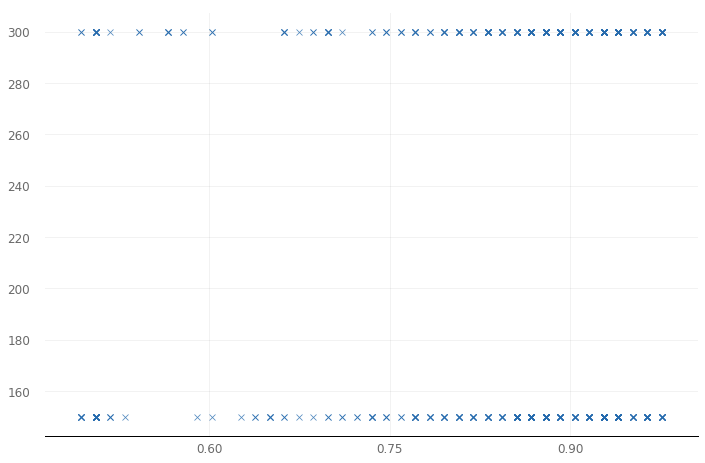

In [28]:
# a regression plot for two dimensions 
r.plot_regs("val_acc", "epochs")

None


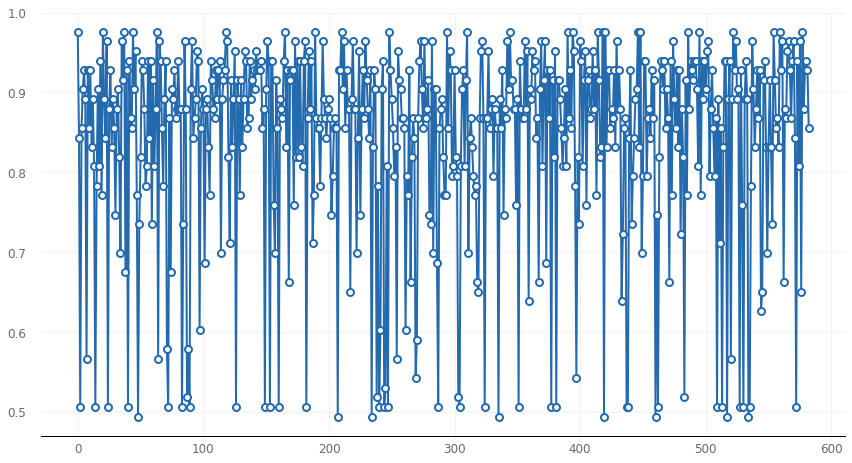

In [29]:
# line plot
print(r.plot_line("val_acc"))

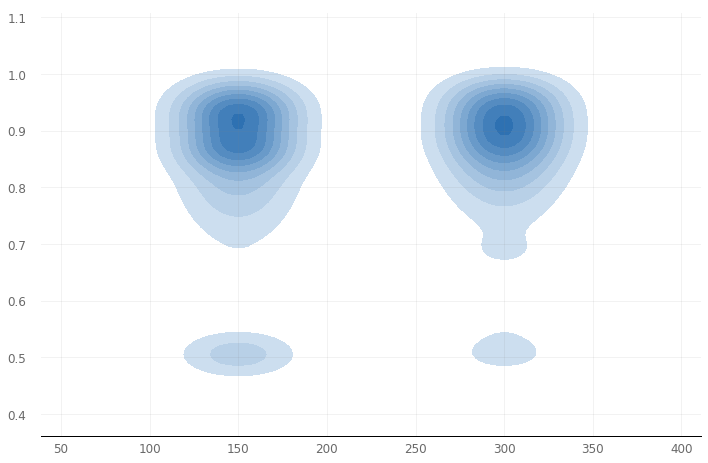

In [31]:
# up to two dimensional kernel density estimator
r.plot_kde("epochs","val_acc")

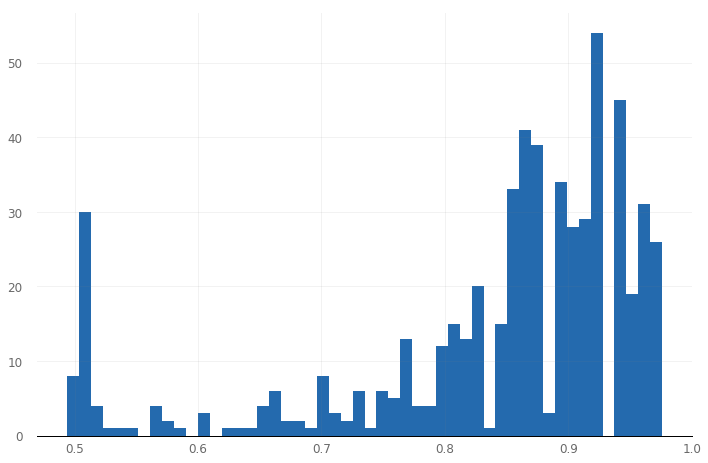

In [32]:
# a simple histogram
r.plot_hist(bins=50)

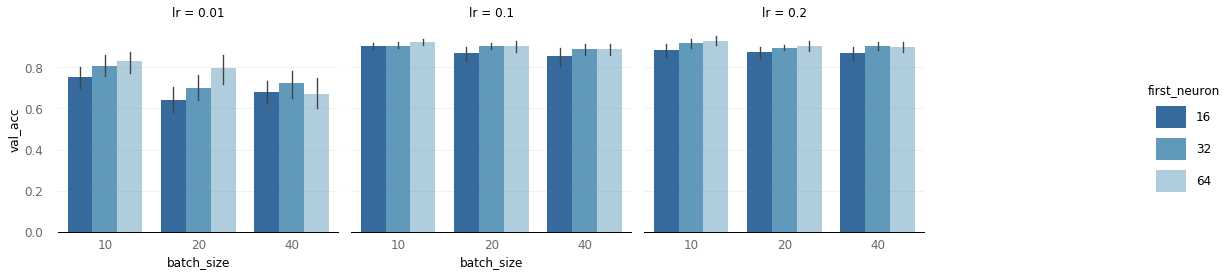

In [33]:
# a four dimensional bar grid
r.plot_bars('batch_size', 'val_acc', 'first_neuron', 'lr')

## Evaluating models
Models can be evaluated with Evaluate() against a k-fold cross-validation. Ideally at least 50% of the data, or more if possible, is kept completely out of the Scan process and only exposed into Evaluate once one or more candidate models have been identified.

**See source code at** https://github.com/autonomio/talos/blob/daily-dev/talos/commands/evaluate.py


In [0]:
# k-fols crossvalidation with 10 folds, from test data
# we're going to validate using the f-measure or harmonic mean since 
# combines precision and recall (optimize on that)
# https://en.wikipedia.org/wiki/Precision_and_recall#F-measure

e = ta.Evaluate(h)

e.evaluate(x=x_test, y=y_test,
           folds=10,
           shuffle=True,
           metric='val_acc',
           mode='binary',
           print_out=True)

## Evaluating model on test set

### Classification report AND Confusion matrix

Here we will iterate over all possible evaluation criteria to generate a matrix of confusion matrices. Each evaluation criteria (acc, val_acc, etc.) index the round (model) with the highest value on that criteria from all the trained models.

After model selection, we make predictions on the test set. The results for the confusion matrix and the classification report are storaged in a pandas dataframe for each model-criteria pair. 

- **accuracy:** true positives + true negatives/ total results OR OR *“for all instances, what percent was correct?”*
- **precision:** true positives / false positives + true positives OR *“for all instances classified positive, what percent was correct?”*
- **recall:** true positives / true positives + false negatives   OR  “for all instances that were actually positive, what percent was classified correctly?”
- **f1-score:** 2 * (precision * recall)/(precision + recall) // The F1 score is a weighted harmonic mean of precision and recall such that the best score is 1.0 and the worst is 0.0. 
-  **support:** is the number of actual occurrences of the class in the specified dataset. Imbalanced support in the training data may indicate structural weaknesses in the reported scores of the classifier and could indicate the need for stratified sampling or rebalancing

**See documentation at** https://www.scikit-yb.org/en/latest/api/classifier/classification_report.html

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from scipy.stats import norm
import math
import pandas as pd

In [0]:
# Lists to store values
# List of performance measures to evaluate models (criteria list)
# List of labels to create dataframe

# Confusion matrix values as frequency
true_neg_l = []
false_pos_l = []
false_neg_l = []
true_pos_l = []

# Confusion matrix values as percentage
true_neg_per_l = []
false_pos_per_l = []
false_neg_per_l = []
true_pos_per_l = []

# Other metrics for all
hit_rate_l = []
false_alarm_rate_l = []
d_sensitivity_l = []
c_bias_l = []
accuracy_score_l = []

# Metrics to pick model and test model perfomance
criteria_list= ['acc', 'fmeasure_acc', 'recall_acc', 'precision_acc', 'matthews_correlation_acc',
               'val_acc', 'val_fmeasure_acc', 'val_recall_acc', 'val_precision_acc', 'val_matthews_correlation_acc']

# Labels to build dataframe
labels = ["Criteria","True_Negatives", "False_Positives", "False_Negatives", "True_Positives",
          "True_Negatives_Per", "False_Positives_Per", "False_Negatives_Per", "True_Positives_Per",
          "Hit_Rate", "False_Alarm_Rate", "d_sensitivity", "c_bias", "Test_Accuracy_Score"]


In [0]:
# Here we loop over the best models based on relevant criterias to build a 
# confusion matrix and classification report 

# Reference to compute d' and c-bias https://lindeloev.net/calculating-d-in-python-and-php/

for criteria in criteria_list:
  # get best model id from the scan object based on some perfomance measure
  model_id = best_model(h, criteria, False)
  # activate best model based on model id
  model = activate_model(h, model_id)
  
  # predicted labels
  y_pred = model.predict_classes(x_test) 
  # true labels
  y_true = y_test 
  
  # Compute confusion matrix values
  true_neg, false_pos, false_neg, true_pos = confusion_matrix(y_true, y_pred).ravel()
  true_neg_l.append(true_neg)
  false_pos_l.append(false_pos)
  false_neg_l.append(false_neg)
  true_pos_l.append(true_pos)
  
  # Compute confusion matrix as percentage
  all_negatives = true_neg + false_pos
  all_positives = false_neg + true_pos
  true_neg_per = true_neg / all_negatives
  true_neg_per_l.append(true_neg_per)
  false_pos_per = false_pos / all_negatives
  false_pos_per_l.append(false_pos_per)
  false_neg_per = false_neg / all_positives
  false_neg_per_l.append(false_neg_per)
  true_pos_per = true_pos / all_positives
  true_pos_per_l.append(true_pos_per)
  
  # Compute Hit rate and avoid d' infinity
  hit_rate = true_pos / (true_pos + false_neg)
  if hit_rate == 1: 
    hit_rate = 1 - half_hit
  if hit_rate == 0: 
    hit_rate = half_hit
  hit_rate_l.append(hit_rate)  
  
  # Compute False alarm rate and avoid d' infinity
  false_alarm_rate = false_pos / (false_pos + true_neg)
  if false_alarm_rate == 1: 
      false_alarm_rate = 1 - half_fa
  if false_alarm_rate == 0: 
      false_alarm_rate = half_fa
  false_alarm_rate_l.append(false_alarm_rate) 
  
  # get z-score
  Z = norm.ppf
  
  # Compute Sensitivity - d'
  d_sensitivity = Z(hit_rate) - Z(false_alarm_rate)
  d_sensitivity_l.append(d_sensitivity)
  
  # Compute Bias - c
  c_bias = -(Z(hit_rate) + Z(false_alarm_rate)) / 2
  c_bias_l.append(c_bias)
  
  # Compute test accuracy
  acc = accuracy_score(y_true, y_pred)
  accuracy_score_l.append(acc)

In [82]:
# Build classification report dataframe 
data = list(zip(criteria_list, true_neg_l, false_pos_l, false_neg_l, true_pos_l,
                true_neg_per_l, false_pos_per_l, false_neg_per_l,true_pos_per_l,
                hit_rate_l,false_alarm_rate_l, d_sensitivity_l, c_bias_l, 
                accuracy_score_l))

assert len(criteria_list) == len(data), "criteria list and data don't match"

classification_report = pd.DataFrame(data, columns=labels, index = None )

# Now we can look the report in one place
classification_report 
# We can pick the one with the best numbers based on any criteria to deploy

,Criteria,True_Negatives,False_Positives,False_Negatives,True_Positives,True_Negatives_Per,False_Positives_Per,False_Negatives_Per,True_Positives_Per,Hit_Rate,False_Alarm_Rate,d_sensitivity,c_bias,Test_Accuracy_Score
0,acc,50,15,7,6,0.769231,0.230769,0.538462,0.461538,0.461538,0.230769,0.639757,0.416437,0.717949
1,fmeasure_acc,50,15,7,6,0.769231,0.230769,0.538462,0.461538,0.461538,0.230769,0.639757,0.416437,0.717949
2,recall_acc,50,15,7,6,0.769231,0.230769,0.538462,0.461538,0.461538,0.230769,0.639757,0.416437,0.717949
3,precision_acc,50,15,7,6,0.769231,0.230769,0.538462,0.461538,0.461538,0.230769,0.639757,0.416437,0.717949
4,matthews_correlation_acc,50,15,7,6,0.769231,0.230769,0.538462,0.461538,0.461538,0.230769,0.639757,0.416437,0.717949
5,val_acc,54,11,9,4,0.830769,0.169231,0.692308,0.307692,0.307692,0.169231,0.454807,0.729806,0.743590
6,val_fmeasure_acc,51,14,7,6,0.784615,0.215385,0.538462,0.461538,0.461538,0.215385,0.691317,0.442217,0.730769
7,val_recall_acc,35,30,5,8,0.538462,0.461538,0.384615,0.615385,0.615385,0.461538,0.389940,-0.098411,0.551282
8,val_precision_acc,50,15,7,6,0.769231,0.230769,0.538462,0.461538,0.461538,0.230769,0.639757,0.416437,0.717949
9,val_matthews_correlation_acc,50,15,7,6,0.769231,0.230769,0.538462,0.461538,0.461538,0.230769,0.639757,0.416437,0.717949


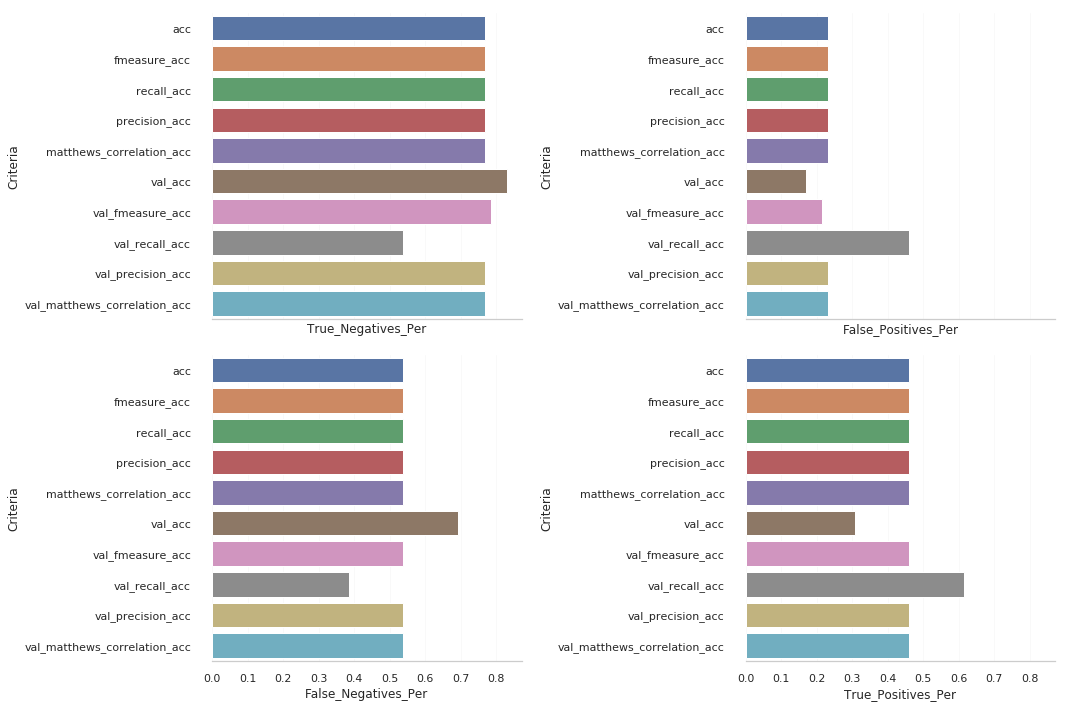

In [83]:
import seaborn as sns
sns.set(style="whitegrid")

f, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True)
sns.despine(left=True)

sns.barplot(x="True_Negatives_Per", y= "Criteria", data=classification_report, ax=axes[0, 0])
sns.barplot(x="False_Positives_Per", y= "Criteria", data=classification_report, ax=axes[0, 1])
sns.barplot(x="False_Negatives_Per", y= "Criteria", data=classification_report, ax=axes[1, 0])
sns.barplot(x="True_Positives_Per", y= "Criteria", data=classification_report, ax=axes[1, 1])


plt.tight_layout()
plt.savefig('confusion_matrix_percentage_exp1.pdf')

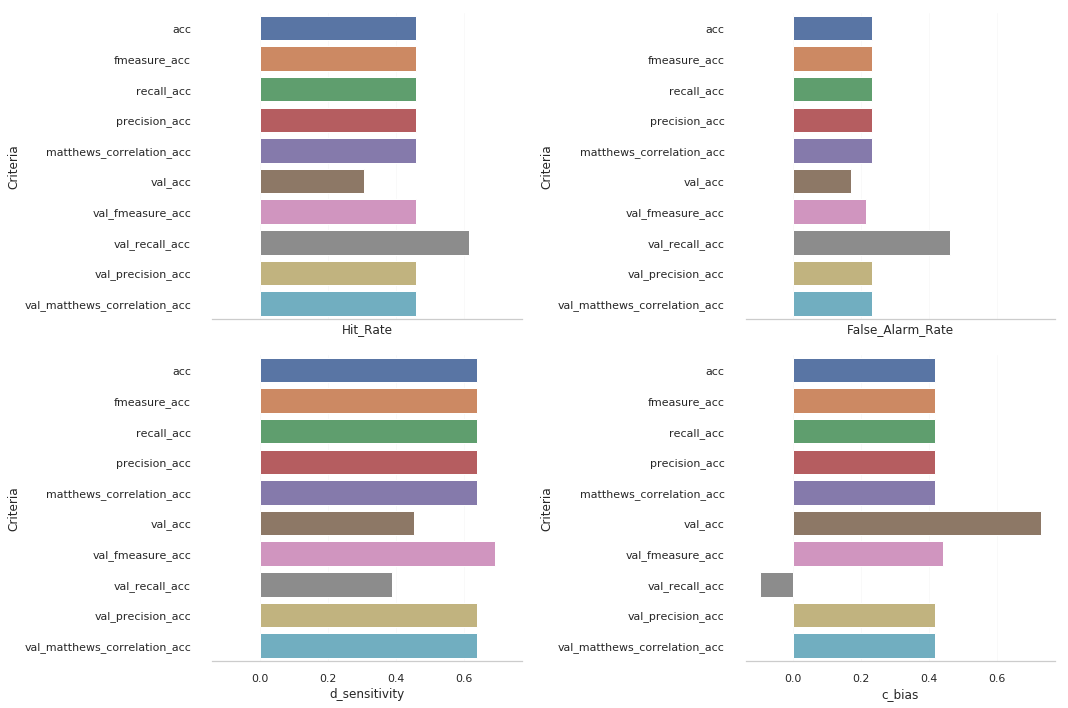

In [85]:
sns.set(style="whitegrid")

f, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True)
sns.despine(left=True)

sns.barplot(x="Hit_Rate", y= "Criteria", data=classification_report, ax=axes[0, 0])
sns.barplot(x="False_Alarm_Rate", y= "Criteria", data=classification_report, ax=axes[0, 1])
sns.barplot(x="d_sensitivity", y= "Criteria", data=classification_report, ax=axes[1, 0])
sns.barplot(x="c_bias", y= "Criteria", data=classification_report, ax=axes[1, 1])

plt.tight_layout()
plt.savefig('signal_detection_report_exp1.pdf')

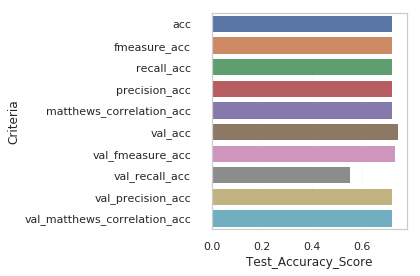

In [87]:
sns.set(style="whitegrid")

#f, axes = plt.subplots(ncols=2, figsize=(15, 10), sharex=True)
sns.despine(left=True)

sns.barplot(x="Test_Accuracy_Score", y= "Criteria", data=classification_report)

plt.tight_layout()
plt.savefig('test_accuracy_exp1.pdf')

In [0]:
# save the model on a csv file
exp_n = '1'
file_name = 'classification_report_dap_' + exp_n + '.csv'
classification_report.to_csv(file_name, sep=',')

## Selecting best model on test set

In [109]:
# Based on the analysis of the performance metrics, on exp1, val_fmeasure_acc
# is the model that best balance all requirements (test accuracy, hit rate, false alarm rate, bias, sensitivity)
best_round =r.rounds2high('val_fmeasure_acc') # round 63 for exp1

h.saved_models[best_round] # print parameters best model 

'{"class_name": "Sequential", "config": {"name": "sequential_1", "layers": [{"class_name": "Dense", "config": {"name": "dense_1", "trainable": true, "batch_input_shape": [null, 25088], "dtype": "float32", "units": 16, "activation": "sigmoid", "use_bias": true, "kernel_initializer": {"class_name": "RandomNormal", "config": {"mean": 0.0, "stddev": 0.05, "seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}, {"class_name": "Dropout", "config": {"name": "dropout_1", "trainable": true, "rate": 0.1, "noise_shape": null, "seed": null}}, {"class_name": "Dense", "config": {"name": "dense_2", "trainable": true, "units": 1, "activation": "sigmoid", "use_bias": true, "kernel_initializer": {"class_name": "RandomNormal", "config": {"mean": 0.0, "stddev": 0.05, "seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_re

## Deploying models

Once the right model or models have been found, you can create a deployment package with Deploy() which is then easy to transfer to a production or other environment, send via email, or upload to shared remote location. Best model is automatically chosen based on a given metric ('val_acc' by default).

The Deploy package is a zip file that consist of:

- details of the scan
- model weights
- model json
- results of the experiment
- sample of x data
- sample of y data

**See source code at** https://github.com/autonomio/talos/blob/daily-dev/talos/commands/deploy.py

In [103]:
# By default selects the model with best validation accuracy
# Other metrics can be specified
# name code: "[dataset]-[experiment-number]-[rounds/models]-[seleccion-criteria]-[%-searched]"
# Based on the evaluated metrics, I'll pick validation f-measure accuracy as criteria (val_fmeasure_acc)

exp_n = '1_'
metric = 'val_fmeasure_acc_'
rounds = str(r.rounds())
proportion = '_15_percet_sample'
filename = 'dap_' + 'exp' + exp_n + metric + 'rounds' + rounds + proportion
ta.Deploy(h, filename, metric='val_fmeasure_acc')

Deploy package b have been saved.


## Restoring models
Restores the scan_object that had been stored locally as a result of talos.Deploy

**See source code at** https://github.com/autonomio/talos/blob/daily-dev/talos/commands/restore.py 

In [0]:
# BEFORE RESTORING
# This is temporary. Numpy version 1.16.2. has allow_pickle as FALSE which creates a problem
!pip install numpy==1.16.1
import numpy as np

In [0]:
# Restore model from local environment
model_name = # 'NAME_ZIP_FILE.zip'
drawings = ta.Restore(model_name)

In [0]:
# make predictions with the model
drawings.model.predict(x_test)[0:9,] # print first 10

In [0]:
# get the meta-data for the experiment/optimization
print(drawings.details)

In [0]:
# get the hyperparameter space boundary for the experiment/optimization
print(drawings.params)

In [0]:
# sample of x and y data, returns pandas dataframe
print(drawings.x.iloc[0:3, 0:3]) # print first 3 rows and columns
print(drawings.y.iloc[0:3]) # print first 3 rows 

In [0]:
# the results dataframe
drawings.results[0:3] # print first 3 rows

# Resources
- **Talos repo**: https://github.com/autonomio/talos
- **Talos example**:  https://nbviewer.jupyter.org/github/autonomio/talos/blob/master/examples/Hyperparameter%20Optimization%20on%20Keras%20with%20Breast%20Cancer%20Data.ipynb